# Part 1 - Exploratory Data Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence

plt.rcParams["figure.figsize"] = (20,10)

In [3]:
df = pd.read_json(r'C:\Users\Evan\Desktop\ultimate_challenge\logins.json')

In [4]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


### No missing data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


### login_time is already in datetime format

In [6]:
df.login_time.dtype

dtype('<M8[ns]')

### How far does the data span?
#### Almost 3 and a half months.

In [7]:
print('Earliest date: {}'.format(min(df['login_time'])))
print('Latest date: {}'.format(max(df['login_time'])))

Earliest date: 1970-01-01 20:12:16
Latest date: 1970-04-13 18:57:38


### Aggregate in 15-minute intervals
#### First set the `login_time` as the index

In [8]:
df.set_index('login_time', inplace = True)

#### Give the aggregator a column to count, and then aggregate.

In [9]:
df['count'] = 1
df_agg = df.resample('15min').count()

#### Create `day_of_week` column

In [10]:
df_agg['day_of_week'] = df_agg.index.day_name()

### We'll start with the simplest visualization. It appears that there is a weekly cycle with peaks occuring roughly once a week (possibly weekends).

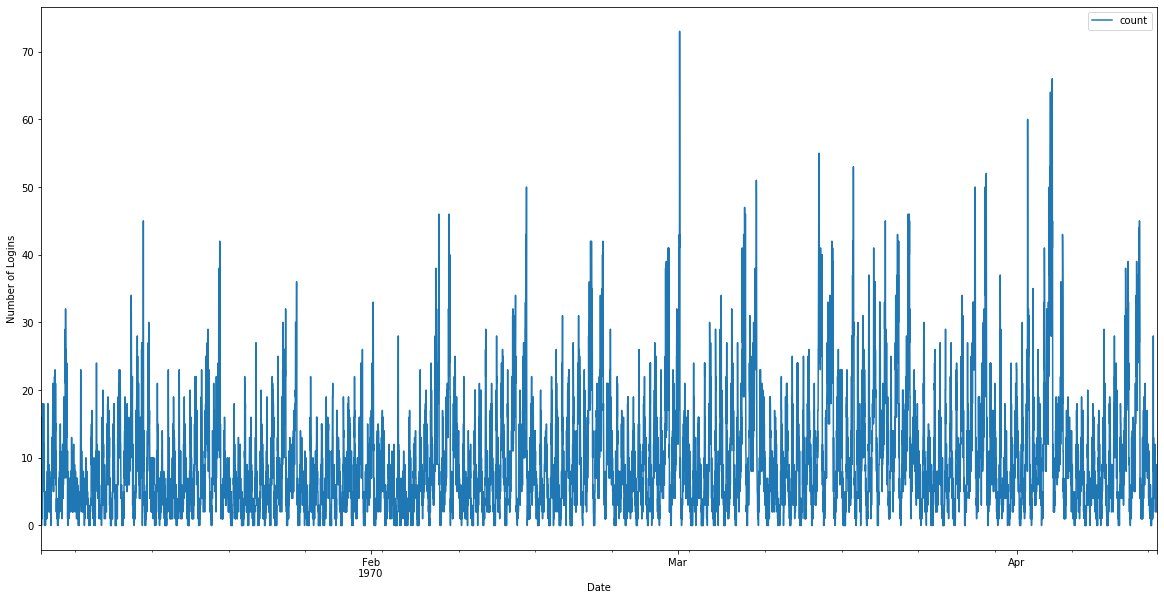

In [11]:
df_agg.plot()
plt.xlabel('Date')
plt.ylabel('Number of Logins')
plt.show()

### Indeed the weekends do have the most logins

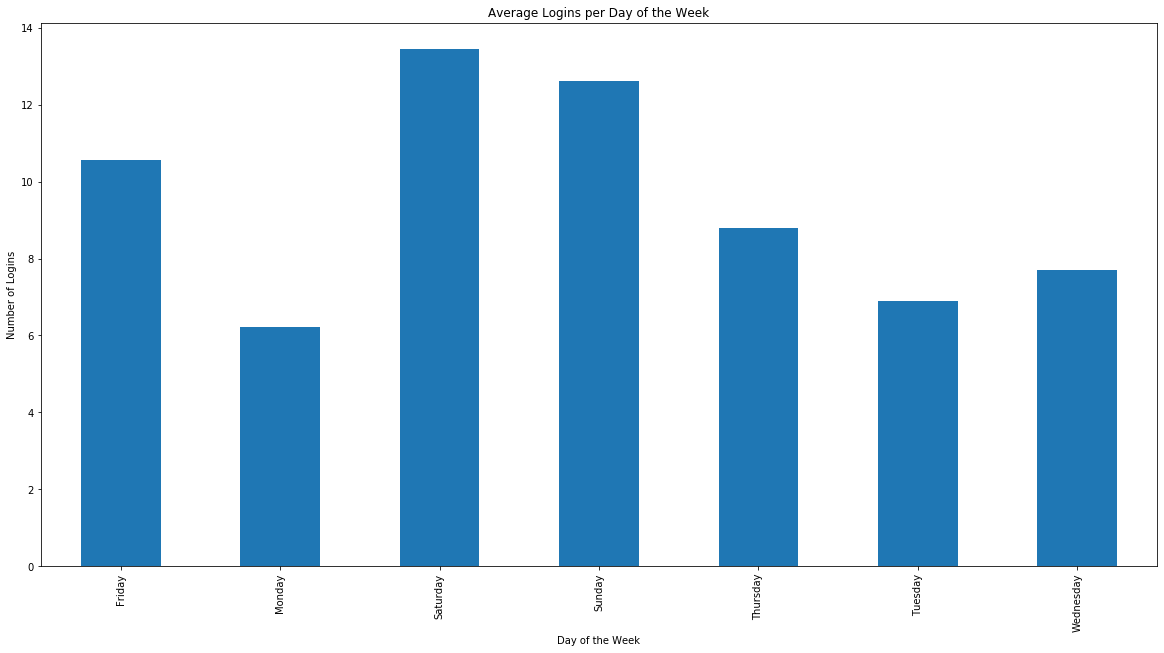

In [12]:
df_agg.groupby('day_of_week').mean().unstack()['count'].plot(kind='bar')
plt.title('Average Logins per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Logins')
plt.show()

### We can see that weekends follow very different cycles than weekdays
* Weekend logins peak at around 5:00AM
* Weekday logins typically peak at around 11:15AM
* Friday logins peak at around 10:30PM
* There are fewest logins between 6:00AM and 10:00AM
* Late night logins increase from Monday to Friday

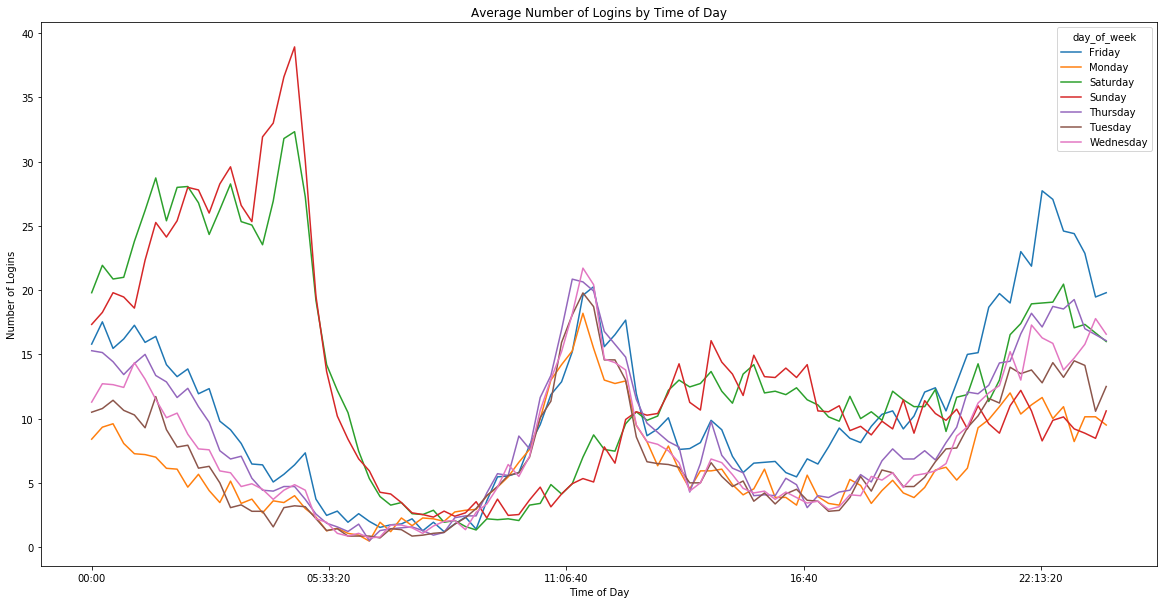

In [13]:
df_agg.groupby([df_agg.index.time, 'day_of_week']).mean().unstack()['count'].plot()

plt.ylabel('Number of Logins')
plt.xlabel('Time of Day')
plt.title('Average Number of Logins by Time of Day')
plt.show()

# Part 2 - Experiment and metric design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. **What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?**

    If I were to conduct this experiment, I would want to look at average wait time as a key metric. Based on the description of Gotham and Metropolis, we can see that the demand for drivers will be different at different times. However, because toll costs disincentivize drivers from moving between cities, they are less likely to move where demand is high. If demand is higher than the number of drivers in a given city, wait times will increase, which is bad for business. If we reimburse toll costs, then drivers can freely move to where there is greater demand, and thus we should expect to see wait times drop. 


2. **Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:**

    a. how you will implement the experiment
    
    b. what statistical test(s) you will conduct to verify the significance of the observation
    
    c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.    
    
    a. To implement this experiment I would inform drivers that toll costs will be reimbursed for two weeks as part of an experiment. I would then collect the data and compare it to the mean wait for each city. This assumes that there is no seasonal rhythms of wait times. If there were then you would want to compare it to the same two weeks from the previous year. Also, I would compare weekdays to weekdays and weekends to weekends. 
    
    b. I would use a Z-test to compare means, and if the Z-score for the mean during the experiement was beyond the critical value for .05 significance, then I would consider the results significant.
    
    c. Because I would run separate tests for each city and also for weekends and weekdays, I could provide specific recommendations given the results. For example, if wait times were reduced during the weekdays, but not the weekends, then I would reccomend to only reimburse toll costs during weekdays. If wait times were reduced in Gotham, but not Metropolis, then I would recommend reimbursing toll costs for drivers who live in Metropolis so that they can freely travel to Gotham to meet the demand.

# Part 3 - Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

In [14]:
raw_df = pd.read_json(r'C:\Users\Evan\Desktop\ultimate_challenge\ultimate_data_challenge.json', convert_dates=['signup_date', 'last_trip_date'])

In [15]:
df = raw_df.copy()
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

### We will start by creating a label `retained`
#### The instructions state that a user is considered retained if they took a ride in the last 30 days, however it does not state on which date the data were collected. The best we can do is check the most recent trip date and assume the data were collected on that day.

In [17]:
print('Most recent trip: {}'.format(max(df.last_trip_date)))

Most recent trip: 2014-07-01 00:00:00


### We will classify users whose last trip was after June 1st as `retained`

In [18]:
df['retained'] = df['last_trip_date'] >= '2014-06-01'

print('Pct of users retained: {}'.format(df.retained.mean()))

Pct of users retained: 0.37608


### Now Let's investigate missing data
#### The missing values for `phone` and `avg_rating_by_driver` make up less than 1% of the data, so we can safely remove those rows.

In [19]:
df.dropna(subset=['phone', 'avg_rating_by_driver'], inplace=True)

#### `avg_rating_of_driver` is missing over 16% of it's data, so we should investigate closer.

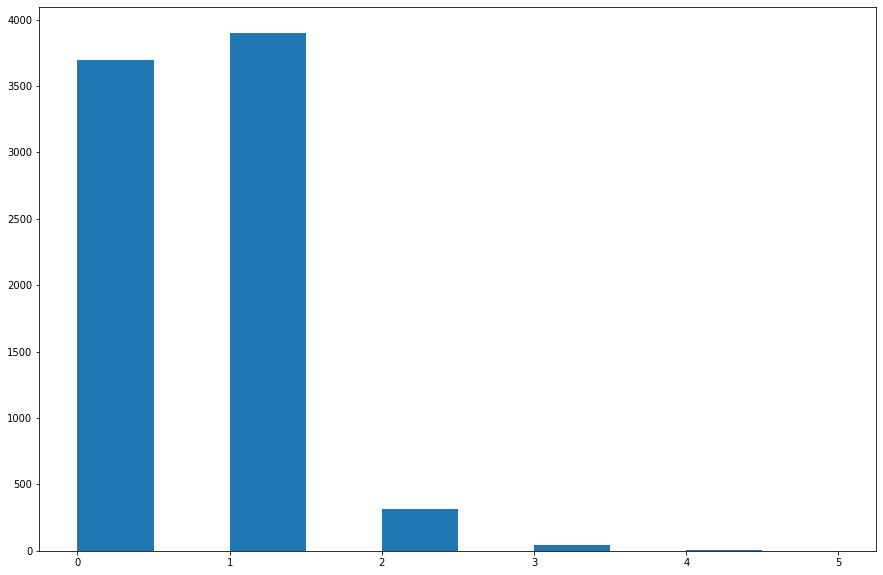

Average number of rides for missing: 0.5896244190428338
Average number of rides for not missing: 2.609675473519122

Pct retained among missing: 0.20097977640999876
Pct retained among not missing: 0.41102666184099407


In [20]:
plt.rcParams["figure.figsize"] = (15,10)
missing = df[df.avg_rating_of_driver.isnull()]
not_missing = df.dropna(subset=['avg_rating_of_driver'])

plt.hist(missing.trips_in_first_30_days)
plt.show()
print('Average number of rides for missing: {}'.format(missing.trips_in_first_30_days.mean()))
print('Average number of rides for not missing: {}'.format(not_missing.trips_in_first_30_days.mean()))
print('')
print('Pct retained among missing: {}'.format(missing.retained.mean()))
print('Pct retained among not missing: {}'.format(not_missing.retained.mean()))

### We can see that users who did not rate their drivers took about 2 fewer rides and were about half as likely to be retained as those who did rate their drivers. This will likely be a strong predictor in our model so we will create a column with this information.

In [21]:
df['no_driver_rating'] = df.avg_rating_of_driver.isnull()

### Now, how to handle the missing data? We don't want to delete those rows, so we must fill them with some data. Let's see how the data are distributed.

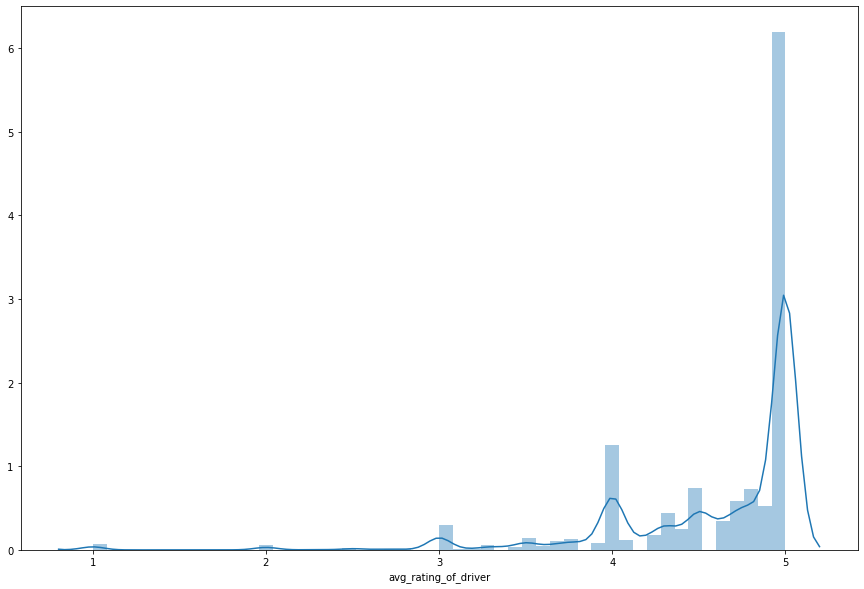

Mean rating: 4.601720352273912
Median rating: 4.9
Most frequent rating: 5.0


In [22]:
plt.rcParams["figure.figsize"] = (15,10)
sns.distplot(df.avg_rating_of_driver)
plt.show()
print('Mean rating: {}'.format(df.avg_rating_of_driver.mean()))
print('Median rating: {}'.format(df.avg_rating_of_driver.median()))
print('Most frequent rating: {}'.format(df.avg_rating_of_driver.mode()[0]))

### The data is very skewed, so it is best to fill missing rows with the median.
 * (It is possible that users who did not rate their drivers had bad experiences and therefor their ratings would be lower than the rest of the population. If that is the case, the `no_driver_rating` column should capture that information.)

In [23]:
df.fillna(df.median(), inplace=True)
len(df)

49406

## We now have a complete dataframe with 49,406 rows. We can do some EDA

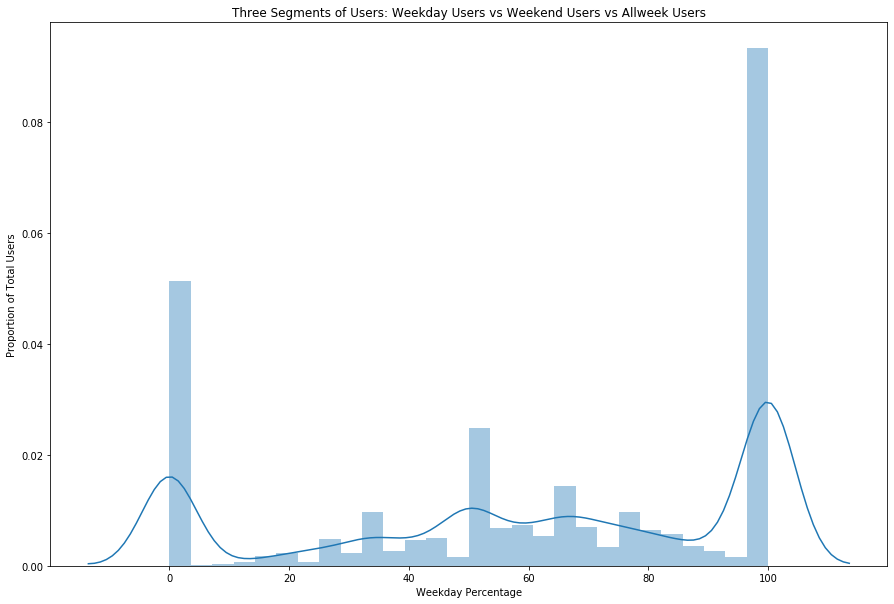

In [24]:
sns.distplot(df['weekday_pct'])
plt.title('Three Segments of Users: Weekday Users vs Weekend Users vs Allweek Users')
plt.ylabel('Proportion of Total Users')
plt.xlabel('Weekday Percentage')
plt.show()

### Based on the above figure, it makes sense to tag users based on their riding behavior

In [25]:
df['weekend_rider'] = df['weekday_pct'] == 0
df['weekday_rider'] = df['weekday_pct'] == 100
df['allweek_rider'] = (df['weekday_pct'] > 0) & (df['weekday_pct'] < 100)

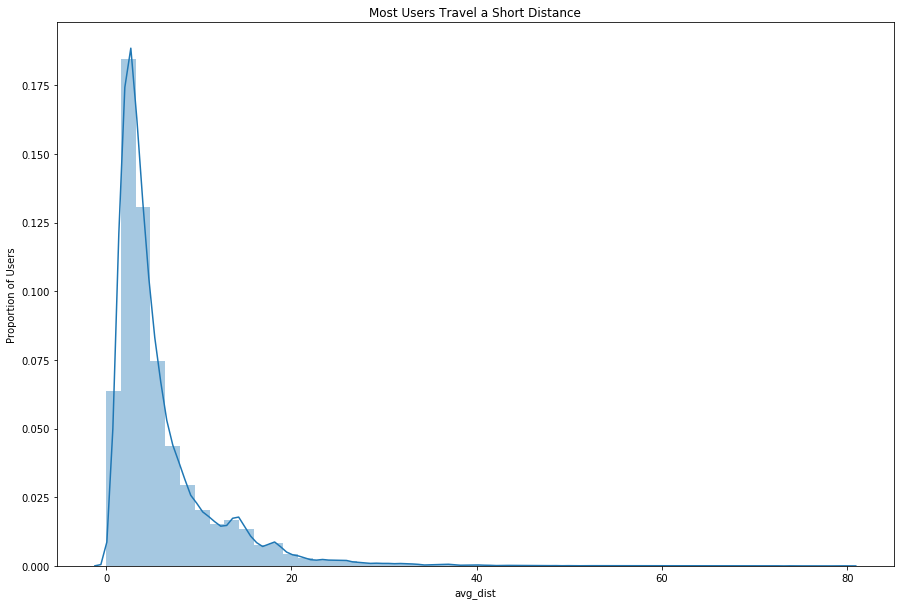

In [26]:
sns.distplot(df['avg_dist'])
plt.ylabel('Proportion of Users')
plt.title('Most Users Travel a Short Distance')
plt.show()

In [27]:
df.corr()['retained']

trips_in_first_30_days    0.210294
avg_rating_of_driver     -0.041192
avg_surge                -0.003434
surge_pct                 0.011697
ultimate_black_user       0.206077
weekday_pct               0.009519
avg_dist                 -0.093581
avg_rating_by_driver     -0.026371
retained                  1.000000
no_driver_rating         -0.159331
weekend_rider            -0.198808
weekday_rider            -0.250204
allweek_rider             0.389600
Name: retained, dtype: float64

### Create dummy variables

In [28]:
df = pd.concat([df, pd.get_dummies(df['phone'], prefix='phone'), pd.get_dummies(df['city'], prefix='city')], axis=1)

### Drop categorical variables

In [29]:
df['ultimate_black_user'] = df['ultimate_black_user'].astype(int)
df['retained'] = df['retained'].astype(int)
df['no_driver_rating'] = df['no_driver_rating'].astype(int)

model_data = df.drop(labels=['city', 'signup_date', 'last_trip_date', 'phone'], axis=1)

### Scale the variables and do train/test split

In [47]:
x = model_data.drop(labels='retained', axis=1)
y = model_data.retained

scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)


X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3, random_state=42)

### Perform tSNE and plot feature space

In [31]:
model = TSNE(learning_rate = 100, random_state=42)
transformed = model.fit_transform(x)

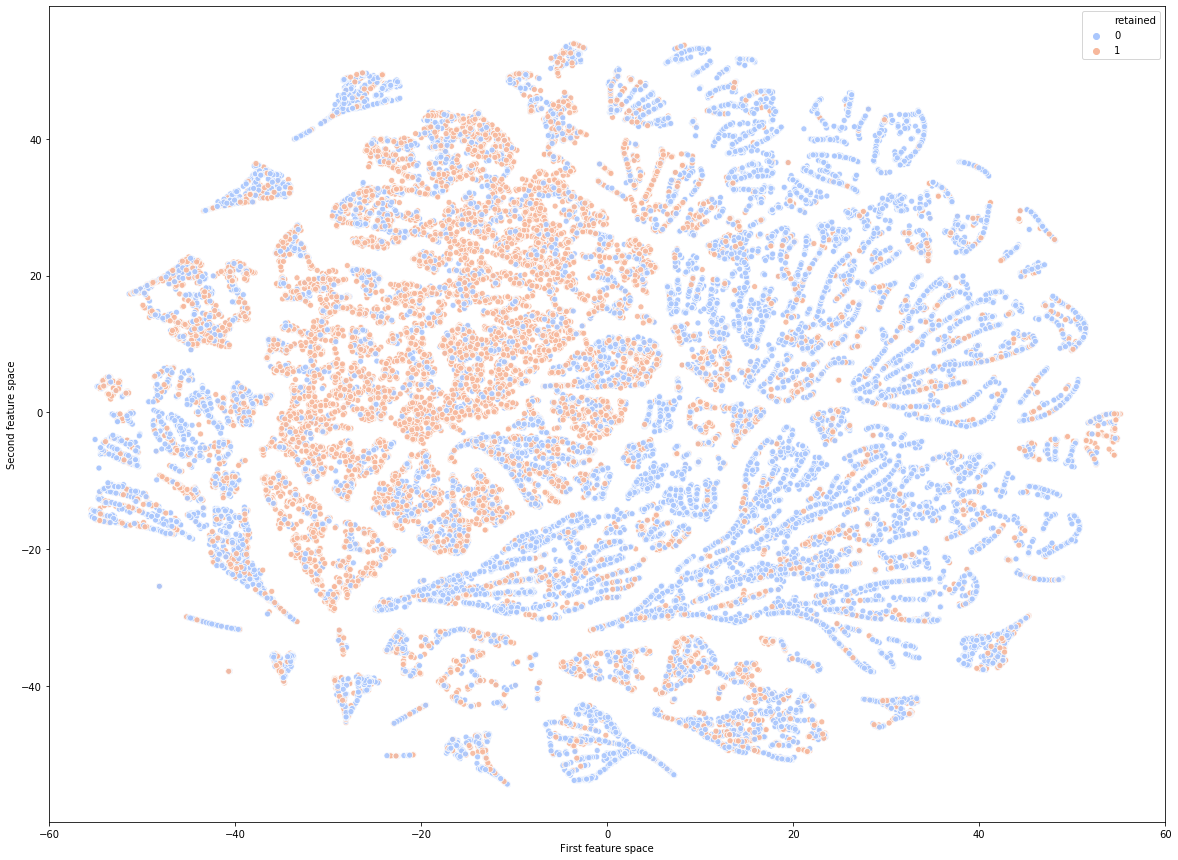

In [32]:
plt.rcParams["figure.figsize"] = (20,15)
xs = transformed[:,0]
ys = transformed[:,1]

sns.scatterplot(xs, ys, hue=y, palette='coolwarm', alpha=0.9)
plt.xlim(-60,60)
plt.xlabel('First feature space')
plt.ylabel('Second feature space')
plt.show()

### Train a Support Vector Classifier with 'radial basis function' kernel

In [33]:
svc = svm.SVC()

param_grid = [
      {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}
 ]

rbf_svc = RandomizedSearchCV(svc, param_distributions=param_grid, cv=3, random_state=42, n_jobs=-1)

rbf_svc.fit(X_train, y_train)

print(rbf_svc.best_params_)
print('rbf_svc score: {}'.format(rbf_svc.score(X_test, y_test)))

C:\Users\Evan\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


{'kernel': 'rbf', 'gamma': 0.0001, 'C': 100}
rbf_svc score: 0.756375657805964


### The linear kernel for SVC is not optimized, so to test it I need to use the LinearSVC estimator. This requires normalization.

In [34]:
normalizer = preprocessing.Normalizer()

X_normalized = normalizer.fit_transform(x)

X1_train, X1_test, y1_train, y1_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

param_grid = [
      {'C': [1, 10, 100, 1000],
      'loss': ['hinge', 'squared_hinge'],
      'tol': [.00001, .0001, .001]}
 ]

svc = svm.LinearSVC()
linear_svc = RandomizedSearchCV(svc, param_distributions = param_grid, cv = 3, random_state=42, n_jobs=-1)

linear_svc.fit(X1_train, y1_train)

print(linear_svc.best_params_)
print('Score: {}'.format(linear_svc.score(X1_test, y1_test)))

{'tol': 0.001, 'loss': 'squared_hinge', 'C': 10}
Score: 0.7235190932397787


### Train Random Forest Classifier

In [35]:
param_grid = {'bootstrap': [True, False],
     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10],
     'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

rf = RandomForestClassifier()

rfc = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, cv = 3, random_state=42, n_jobs=-1)

rfc.fit(X_train, y_train)

print(rfc.best_params_)
print('Random Forest score: {}'.format(rfc.score(X_test, y_test)))

{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}
Random Forest score: 0.78606126028876


### Train Gradient Boosting Classifier

In [36]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [60, 70, 80, 90, 100, 110, 120, 150, 200],
    'min_samples_split': [350],
    'subsample': [0.8]
}

gb = GradientBoostingClassifier()

gbc = RandomizedSearchCV(gb, param_distributions=param_grid, cv=3, random_state=42, n_jobs=-1)

gbc.fit(X_train, y_train)

print(gbc.best_params_)
print('Gradient Boosting Score: {}'.format(gbc.score(X_test, y_test)))

{'subsample': 0.8, 'n_estimators': 90, 'min_samples_split': 350, 'learning_rate': 0.2}
Gradient Boosting Score: 0.7915935771150991


### Compare models with ROC curve

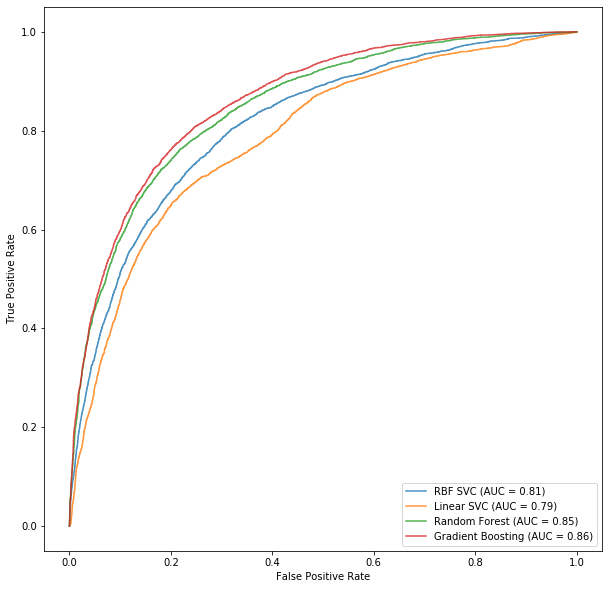

In [37]:
plt.rcParams["figure.figsize"] = (10,10)
fig, ax = plt.subplots()

rbf_svc_disp = plot_roc_curve(rbf_svc, X_test, y_test, ax=ax, alpha=0.8, name='RBF SVC')
linear_svc_disp = plot_roc_curve(linear_svc, X1_test, y1_test, ax=ax, alpha=0.8, name='Linear SVC')
rfc_disp = plot_roc_curve(rfc, X_test, y_test, ax=ax, alpha=0.8, name = 'Random Forest')
gbc_disp = plot_roc_curve(gbc, X_test, y_test, ax=ax, alpha=0.8, name = 'Gradient Boosting')

plt.show()

### Plot feature importance

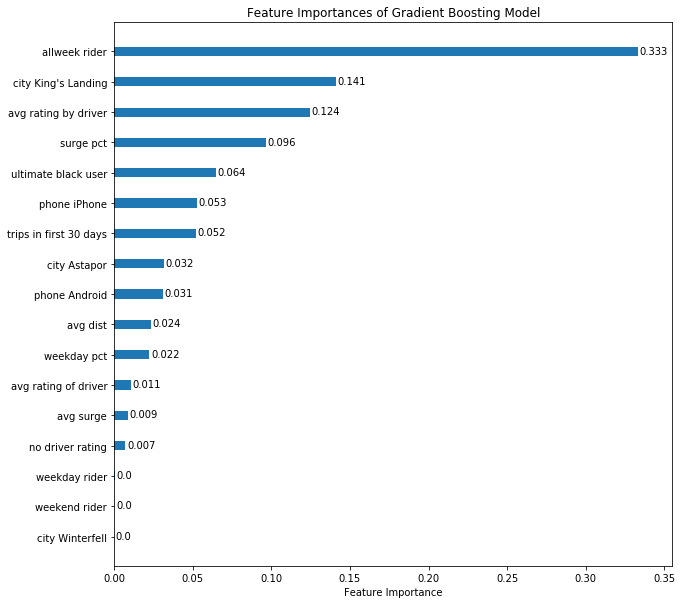

In [49]:
features = [sub.replace('_', ' ') for sub in x.columns]
importances = pd.DataFrame(list(zip(features, gbc.best_estimator_.feature_importances_)),
                              columns=['feature', 'importance'])
importances.sort_values(by='importance', ascending=True, inplace=True)

ax = plt.barh(importances.feature, importances.importance, height=0.3, align='center')
plt.xlabel('Feature Importance')
plt.title('Feature Importances of Gradient Boosting Model')

for i in ax.patches:
    plt.text(i.get_width()+.001, i.get_y()+0.08, 
           str(round(i.get_width(),3)))
plt.xlim([0,.355])
plt.show()

### Conclusions and Suggestions
* What can we take from these results?
* We'll investigate the 4 most important features

### Feature 1 - Allweek Users
* Allweek riders are much more likely to be retained
* Give weekend riders promotions on weekdays and vice verse in order to promote allweek behavior

In [52]:
df['behavior'] = df[['weekend_rider', 'weekday_rider', 'allweek_rider']].idxmax(axis=1)

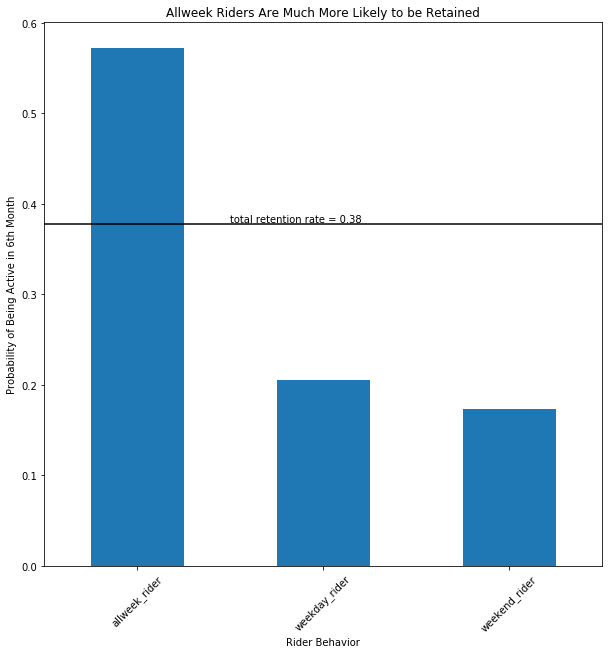

In [59]:
df.groupby(by='behavior').mean()['retained'].plot(kind='bar')
plt.hlines(df['retained'].mean(), -1, 5)
plt.text(0.5, df['retained'].mean()+.002, 'total retention rate = {}'.format(round(df['retained'].mean(), 2)))
plt.xlabel('Rider Behavior')
plt.ylabel('Probability of Being Active in 6th Month')
plt.title('Allweek Riders Are Much More Likely to be Retained')
plt.xticks(rotation=45)
plt.show()

### Feature 4 - King's Landing Users
* Much more likely to be retained
* Investigate what is different about King's Landing (wait times lower?, younger population?, more affluent?)

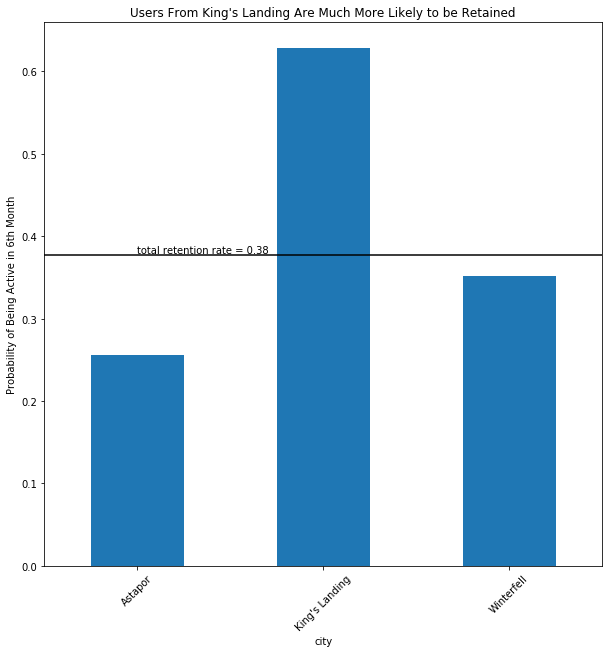

In [61]:
raw_df['retained'] = raw_df['last_trip_date'] >= '2014-06-01'
raw_df.groupby(by='city').mean()['retained'].plot(kind='bar')
plt.hlines(df['retained'].mean(), -1, 100)
plt.text(0, df['retained'].mean()+.002, 'total retention rate = {}'.format(round(df['retained'].mean(), 2)))
plt.ylabel('Probability of Being Active in 6th Month')
plt.title('Users From King\'s Landing Are Much More Likely to be Retained')
plt.xticks(rotation=45)
plt.show()

### Feature 2 - Average rating by driver
* Users with average rating between 4 and 5 most likely to be retained
* The fact that users with average rating of 5 are not retained is likely self fulfilling (they simply take fewer rides than others)

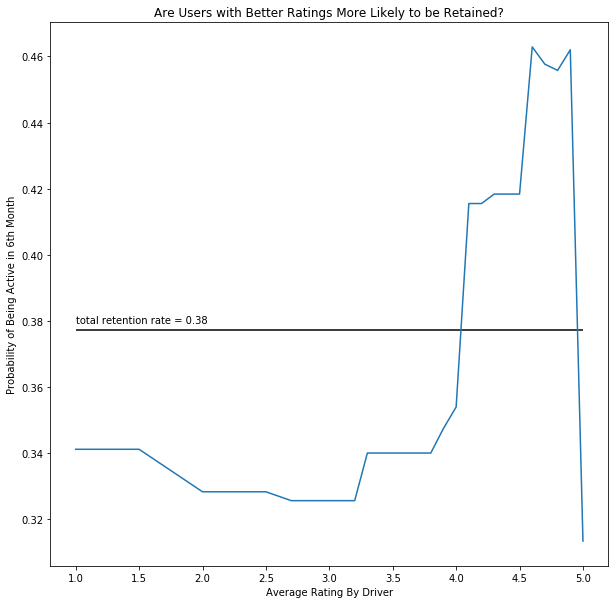

In [39]:
# Retrieve partial dependence of 'avg_rating_by_driver'
pdp, axes = partial_dependence(gbc, X_train, features=[7])

# Inverse transform the values so they can be interpretted on figure
inverse = scaler.inverse_transform(X_train)
seventh = [i[7] for i in inverse]
unique = []
for i in seventh:
    if i not in unique:
        unique.append(i)
unique.sort()

# Plot the figure
plt.plot(unique, pdp[0])
plt.hlines(df['retained'].mean(), 1, 5)
plt.xlabel('Average Rating By Driver')
plt.ylabel('Probability of Being Active in 6th Month')
plt.title('Are Users with Better Ratings More Likely to be Retained?')
plt.text(1, df['retained'].mean()+.002, 'total retention rate = {}'.format(round(df['retained'].mean(), 2)))
plt.show()

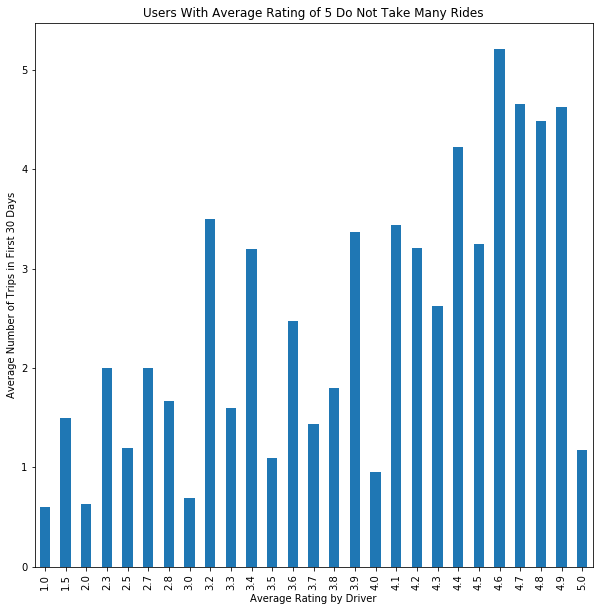

In [40]:
df.groupby(by='avg_rating_by_driver').mean()['trips_in_first_30_days'].plot(kind='bar')
plt.xlabel('Average Rating by Driver')
plt.ylabel('Average Number of Trips in First 30 Days')
plt.title('Users With Average Rating of 5 Do Not Take Many Rides')
plt.show()

### Feature 3 - Average Surge Percentage
* Users who take trips during surge more often are less likely to be retained
* Could possibly offer promotions for users who often ride during surge (loyalty program)

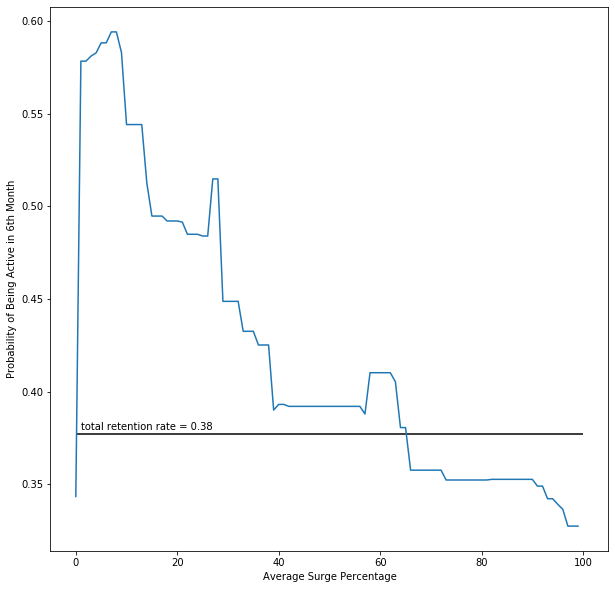

In [41]:
# Retrieve partial dependence of 'avg_rating_by_driver'
pdp, axes = partial_dependence(gbc, X_train, features=[3])

# Plot the figure
plt.plot(range(0,100), pdp[0])
plt.hlines(df['retained'].mean(), 0, 100)
plt.xlabel('Average Surge Percentage')
plt.ylabel('Probability of Being Active in 6th Month')
plt.title('')
plt.text(1, df['retained'].mean()+.002, 'total retention rate = {}'.format(round(df['retained'].mean(), 2)))
plt.show()